In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
from pathlib import Path
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kapturovalexander/bank-credit-scoring")
dataset_path = Path(path).joinpath("bank.csv")

dataset = pd.read_csv(dataset_path, sep=";")
dataset.head()

/home/parth/miniconda3/envs/env-practice-ml-py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
dataset.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [4]:
categorical_cols = dataset.select_dtypes(include="object").columns.to_list()
numerical_cols = dataset.select_dtypes(exclude="object").columns.to_list()

print(categorical_cols)
print(numerical_cols)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [5]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])
    encoders[col] = le

dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3,0


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dataset[numerical_cols] = scaler.fit_transform(dataset[numerical_cols])
# x = scaler.fit_transform(x)

x = dataset.drop(columns=["y"], axis=1, inplace=False)
y = dataset[["y"]]

# dataset.head()

In [7]:
from sklearn.model_selection import train_test_split

X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(
    x, y, test_size=0.2, random_state=4, shuffle=True, stratify=y
)

print(f"Train size: {X_train_og.shape[0]}")
print(f"Test size: {X_test_og.shape[0]}")

Train size: 3616
Test size: 905


In [8]:
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)
x_res_dp, y_res_dp = over_sampler.fit_resample(x, y)

X_train_dp, X_test_dp, y_train_dp, y_test_dp = train_test_split(
    x_res_dp, y_res_dp, test_size=0.2, random_state=4,
    shuffle=True, stratify=y_res_dp
)

In [9]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(
    n_neighbors=2,
    weights="distance",
    algorithm="auto", n_jobs=-1,
)
model.fit(X_train_dp, y_train_dp)

/home/parth/miniconda3/envs/env-practice-ml-py310/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_jobs=-1, n_neighbors=2, weights='distance')

In [10]:
print(model.score(X_test_dp, y_test_dp))
print(model.score(X_test_og, y_test_og))

0.968125
0.943646408839779


In [11]:
from sklearn.metrics import balanced_accuracy_score

print(balanced_accuracy_score(y_test_og, model.predict(X_test_og), adjusted=True))

0.9363295880149813


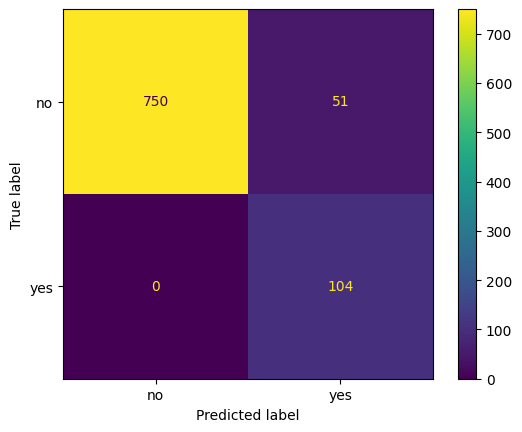

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(
    confusion_matrix(y_test_og, model.predict(X_test_og)),
    display_labels=encoders["y"].inverse_transform(model.classes_)
).plot()

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test_og, model.predict(X_test_og)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       801
           1       0.67      1.00      0.80       104

    accuracy                           0.94       905
   macro avg       0.84      0.97      0.89       905
weighted avg       0.96      0.94      0.95       905



In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test_dp, model.predict(X_test_dp)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       800
           1       0.94      1.00      0.97       800

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600



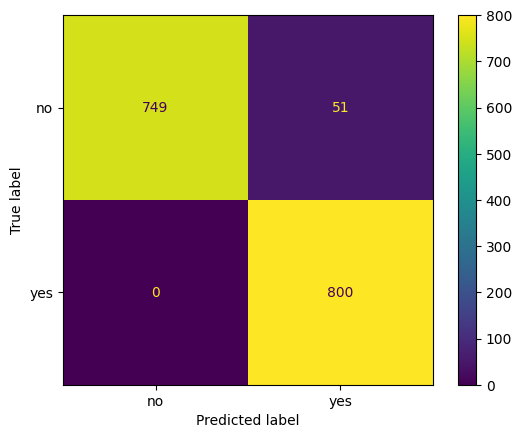

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(
    confusion_matrix(y_test_dp, model.predict(X_test_dp)),
    display_labels=encoders["y"].inverse_transform(model.classes_)
).plot()